# Modelos de Machine learn

## Importações, classes e funções

In [1]:
# Importaçãoes 
import pandas as pd
import warnings
import six
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy import stats
from joblib import dump
sys.modules['sklearn.externals.six'] = six
warnings.filterwarnings('ignore')

In [2]:
url='https://raw.githubusercontent.com/HammadN98/Melhor_ML/main/Dados/output.csv?token=GHSAT0AAAAAABP24NKNP3HZU6LDYKTOYKS6YS3FMHQ'

In [3]:
df_registro_clientes_targets = pd.read_csv(url)
df_registro_clientes_targets.head()

,Unnamed: 0,ID_Cliente,Idade,Qtd_Filhos,Rendimento_Anual,Anos_empregado,Tamanho_Familia,Tem_Carro,Tem_Casa_Propria,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Ocupacao,Mau
0,0,5008806,59.0,0,112500.0,3.1,2.0,1,1,0,0,0,Empregado,Ensino medio,Casado,Casa propria,Seguranca,0
1,1,5008810,52.0,0,270000.0,8.4,1.0,0,1,0,1,1,Associado comercial,Ensino medio,Solteiro,Casa propria,Venda,0
2,2,5008811,52.0,0,270000.0,8.4,1.0,0,1,0,1,1,Associado comercial,Ensino medio,Solteiro,Casa propria,Venda,0
3,3,5008812,62.0,0,283500.0,-1.0,1.0,0,1,0,0,0,Pensionista,Ensino superior,Separado,Casa propria,Outros,0
4,4,5008813,62.0,0,283500.0,-1.0,1.0,0,1,0,0,0,Pensionista,Ensino superior,Separado,Casa propria,Outros,0


In [5]:
# Definição das categorias
colunas_categoricas = ['Tem_Carro',
 'Tem_Casa_Propria',
 'Categoria_de_renda',
 'Grau_Escolaridade',
 'Estado_Civil',
 'Moradia',
 'Tem_telefone_trabalho',
 'Tem_telefone_fixo',
 'Tem_email',
 'Ocupacao']

colunas_quantitativas = ['Idade','Qtd_Filhos','Rendimento_Anual','Anos_empregado','Tamanho_Familia']

colunas_categoricas_nao_binarias = ['Categoria_de_renda','Grau_Escolaridade','Estado_Civil','Moradia','Ocupacao']



A função roda modelo que será usada para rodar o modelo escolido após os pipelines.

In [6]:
SEED = 1561651
def roda_modelo(modelo, dados):

    # separando dados em x e y, e tambem removendo a coluna de ID_cliente
    x = dados.drop(['ID_Cliente', 'Mau'], axis=1)
    y = dados.drop('ID_Cliente', axis=1)['Mau']
    
    # Separando dados em treino e teste
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED)

    # Treinando modelo com os dados de treino
    modelo.fit(x_train, y_train)

    # Calculando a probabilidade e calculando o AUC
    prob_predic = modelo.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f"AUC {auc}")
    
    # Separando a probabilidade de ser bom e mau, e calculando o KS
    data_bom = np.sort(modelo.predict_proba(x_test)[:, 1])
    data_mau = np.sort(modelo.predict_proba(x_test)[:, 0])
    kstest = stats.ks_2samp(data_bom, data_mau)
    print(f"KS {kstest}")

    # Criando matriz de confusão
    matriz_confusao = plot_confusion_matrix(modelo, x_test, y_test, values_format='.0f', display_labels=['Bons', 'Maus'])
    plt.grid(False)    
    plt.show(matriz_confusao)

    # Fazendo a predicao dos dados de teste e calculando o classification report
    predicao = modelo.predict(x_test)
    print("\nClassification Report")
    print(classification_report(y_test, predicao, zero_division=0))

A Classe Trasnformador que ira fazer as tranformações necessarios para os dados se encaixarem nos modelos.

In [7]:
# PEP8 padrão CamelCase
class Transformador(BaseEstimator, TransformerMixin):
    def __init__( self, colunas_quantitativas, colunas_categoricas):
        self.colunas_quantitativas = colunas_quantitativas
        self.colunas_categoricas = colunas_categoricas
        self.enc = OneHotEncoder()
        self.scaler = MinMaxScaler()

    def fit(self, X, y = None ):
        self.enc.fit(X[self.colunas_categoricas])
        self.scaler.fit(X[self.colunas_quantitativas])
        return self 

    def transform(self, X, y = None):
      
      X_categoricas = pd.DataFrame(data=self.enc.transform(X[self.colunas_categoricas]).toarray(),
                                  columns= self.enc.get_feature_names(self.colunas_categoricas))
      
      X_quantitativas = pd.DataFrame(data=self.scaler.transform(X[self.colunas_quantitativas]),
                                  columns= self.colunas_quantitativas)
      
      X = pd.concat([X_quantitativas, X_categoricas], axis=1)

      return X
Transformador(colunas_quantitativas, colunas_categoricas) 


Transformador(colunas_categoricas=['Tem_Carro', 'Tem_Casa_Propria',
                                   'Categoria_de_renda', 'Grau_Escolaridade',
                                   'Estado_Civil', 'Moradia',
                                   'Tem_telefone_trabalho', 'Tem_telefone_fixo',
                                   'Tem_email', 'Ocupacao'],
              colunas_quantitativas=['Idade', 'Qtd_Filhos', 'Rendimento_Anual',
                                     'Anos_empregado', 'Tamanho_Familia'])

## Inicio das modelagens

Comecei com modelos basicos e sem parametros

AUC 0.5
KS KstestResult(statistic=1.0, pvalue=0.0)


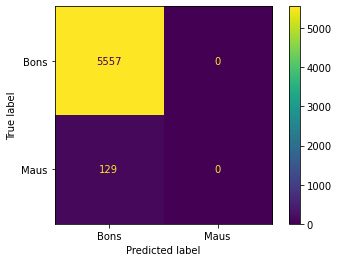


Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5557
           1       0.00      0.00      0.00       129

    accuracy                           0.98      5686
   macro avg       0.49      0.50      0.49      5686
weighted avg       0.96      0.98      0.97      5686



In [8]:
# Modelo base 
pipeline = Pipeline([('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('Modelo', DummyClassifier(strategy='prior'))])   
roda_modelo(pipeline, df_registro_clientes_targets)

A seguir irei rodar uma lista de modelos para serem executados e comparados.
<br>Sendo eles os algoritimos: KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier e RandomForestClassifier.

KNeighborsClassifier()
AUC 0.7181172430051908
KS KstestResult(statistic=0.8100597959901512, pvalue=0.0)


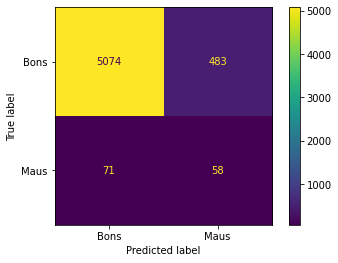


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      5557
           1       0.11      0.45      0.17       129

    accuracy                           0.90      5686
   macro avg       0.55      0.68      0.56      5686
weighted avg       0.97      0.90      0.93      5686

LogisticRegression(random_state=1561651)
AUC 0.5817301455110043
KS KstestResult(statistic=0.1290889905029898, pvalue=1.09559025330554e-41)


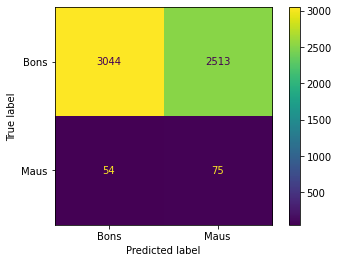


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.55      0.70      5557
           1       0.03      0.58      0.06       129

    accuracy                           0.55      5686
   macro avg       0.51      0.56      0.38      5686
weighted avg       0.96      0.55      0.69      5686

DecisionTreeClassifier(random_state=1561651)
AUC 0.7538519054813191
KS KstestResult(statistic=0.9456559971860711, pvalue=0.0)


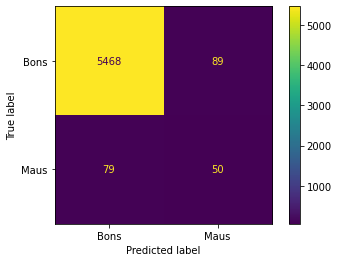


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5557
           1       0.36      0.39      0.37       129

    accuracy                           0.97      5686
   macro avg       0.67      0.69      0.68      5686
weighted avg       0.97      0.97      0.97      5686

RandomForestClassifier(random_state=1561651)
AUC 0.8275336784529046
KS KstestResult(statistic=0.9657052409426662, pvalue=0.0)


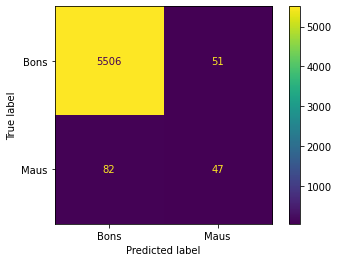


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5557
           1       0.48      0.36      0.41       129

    accuracy                           0.98      5686
   macro avg       0.73      0.68      0.70      5686
weighted avg       0.97      0.98      0.98      5686



In [9]:
classifiers_list = [
    KNeighborsClassifier(5),
    LogisticRegression(random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    RandomForestClassifier(random_state=SEED),
]

for classifier in classifiers_list:
   pipe = Pipeline(steps=[('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)), 
   ('sampling', SMOTE(random_state=SEED)), ("classifier", classifier)])
   print(classifier)
   roda_modelo(pipe, df_registro_clientes_targets)

In [10]:
url2 ='https://raw.githubusercontent.com/HammadN98/Melhor_ML/main/Dados/comparacao_modelos_basico.csv'
comparacao_modelos_basico = pd.read_csv(url2)
comparacao_modelos_basico

,Modelos,AUC,KS,BonsXBons,BonsXMaus,MausXBons,MausXMaus,acc,precision 0,precision 1
0,KNeighborsClassifier(5),NaN,NaN,5074,483,71,58,"0,9","0,99","0,11"
1,LogisticRegression(),"0,58","0,129",3044,2513,54,75,"0,55","0,98","0,03"
2,DecisionTreeClassifier(),"0,75","0,94",5468,89,79,50,"0,97","0,99","0,36"
3,RandomForestClassifier(),"0,82","0,96",5506,51,82,47,"0,98","0,98","0,48"


Visalmente fica facil comparar os resultados obtidos pelos modelos.
<br />E tambem a escolha de por quais prosseguir, sendo estes os DecisionTreeClassifier e o RandomForestClassifier. 
<br />A seguir  os modelos passarão por testes e experimentos em busca dos melhores hyperparametro. 

## HyperParametragem

Aqui irei buscar os parametros que são usados nos modelos escolhidos, DecisionTreeClassifier e o RandomForestClassifier, e após ireis rodar o RandomizedSearchCV nos modelos para buscar seus melhor melhores paramentros para serem usados e então usarei o GridSearchCV com a mesma finalidade. Para posteriormente comparalos e escolher a melhor combinação possivel.

### RandomizedSearchCV

In [10]:
# Parametros em uso do RandomForestClassifier
rfc = RandomForestClassifier(random_state = 42)
from pprint import pprint
pprint(rfc.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


#### RandomFlorestClassifier

In [11]:
# Dicionário para buscar a melhor escolha de parâmetros do RandomForestClassifier com RandomSearchCV
params_RFC_RSCV = {"classifier__max_depth": [3, None],
              "classifier__max_features": [1, 3, 10],
              "classifier__min_samples_split": [1, 3, 10],
              "classifier__min_samples_leaf": [1, 3, 10],
              "classifier__bootstrap": [True, False],
              "classifier__criterion": ["gini", "entropy"],
              "classifier__n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
              "classifier__max_features":['auto', 'sqrt', 'log2']}

In [53]:
# # 20 min p executar
# Usarei o mesmo Pipeline  de dados que anteriormente. 
pipeline_busca_RFC_RSCV = Pipeline([('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)),('sampling', SMOTE(random_state=SEED)), 
                     ('classifier', RandomForestClassifier())])

# Separação basica de dados.
x = df_registro_clientes_targets.drop(['ID_Cliente', 'Mau'], axis=1)
y = df_registro_clientes_targets.drop('ID_Cliente', axis=1)['Mau']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED)

# Então usarei a função busca_RandomizedSearchCV para buscar a melhor coompinação possivel com o RandomizedSearchCV.
rf_random = RandomizedSearchCV(pipeline_busca_RFC_RSCV, params_RFC_RSCV, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)
rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'classifier__n_estimators': 1400,
 'classifier__min_samples_split': 10,
 'classifier__min_samples_leaf': 1,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': None,
 'classifier__criterion': 'entropy',
 'classifier__bootstrap': True}

In [8]:
#Melhores parâmetros do RandomForestClassifier com RandomSearchCV 
RFC_melhores_parametros_RSCV ={
    'n_estimators': 1400,
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': None,
    'criterion': 'entropy',
    'bootstrap': True,
    'random_state': 1561651,
}

RandomForestClassifier com RandomSearchCV
AUC 0.8390646338928622
KS KstestResult(statistic=0.9708054871614492, pvalue=0.0)


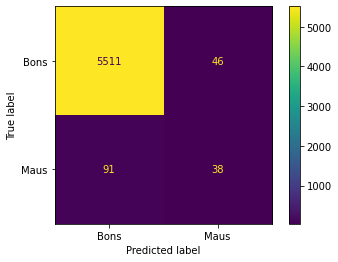


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5557
           1       0.45      0.29      0.36       129

    accuracy                           0.98      5686
   macro avg       0.72      0.64      0.67      5686
weighted avg       0.97      0.98      0.97      5686



In [9]:
# Usando o pipeline para transformar os dados como necessario, balanceando os dados de forma sintetica com o 'SMOTE', 
#e escolhendo o modelo com seu dicionario de melhor combinação de parametros.
pipe_RFC_melhores_parametros_RSCV = Pipeline(steps=[('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)), 
                            ('sampling', SMOTE(random_state=SEED)), 
                            ("modelo", RandomForestClassifier(**RFC_melhores_parametros_RSCV))])
print("RandomForestClassifier com RandomSearchCV")
roda_modelo(pipe_RFC_melhores_parametros_RSCV, df_registro_clientes_targets)

In [19]:
# # for classifier in randoms:
# # Esse fcou ruim.
# pipe_RFC_melhores_parametros_RSCV = Pipeline(steps=[('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)), ('sampling', SMOTE(random_state=SEED)), 
#                                ("modelo", RandomForestClassifier(**RFC_melhores_parametros_RSCV))])
# print("RFC_melhores_parametros_RSCV")
# roda_modelo(pipe_RFC_melhores_parametros_RSCV, df_registro_clientes_targets)

Os resultados sairam aquém do esperado.
<br> Porém sem problema ainda temos o DecisionTreeClassifier para buscar e testar paramentros com o RandomizedSearchCV.

Tive bons resultados com o primeiro modelo, utilizando o RandomForestClassifier, e a combinação de parametros do RandomizedSearchCV
A seguir vou realiar o mesmo processso só uqe desta vez com o DecisionTreeClassifier.

#### DecisionTreeClassifier

In [ ]:
# Parametros em uso do DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 42)
pprint(dtc.get_params())

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}


In [28]:
# Dicionario para buscar a melhor escolha de parametros do DecisionTreeClassifier com RandomSearchCV
params_DTC_RSCV = {"classifier__max_depth": [3, None],
              "classifier__splitter": ['best', 'random'],
              "classifier__min_samples_split": [1, 2, 3, 10],
              "classifier__min_samples_leaf": [1, 2, 3, 10],
              "classifier__criterion": ["gini", "entropy"],
              "classifier__max_features":['auto', 'sqrt', 'log2'],
              "classifier__random_state": [1561651]}

In [24]:
# #nao demora  p executar
# Usarei o mesmo Pipeline  de dados que anteriormente. 
pipeline_busca_DTC_RSCV = Pipeline([('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)),
                            ('sampling', SMOTE(random_state=SEED)),
                            ('classifier', DecisionTreeClassifier())])

# Separação basica de dados.
x = df_registro_clientes_targets.drop(['ID_Cliente', 'Mau'], axis=1)
y = df_registro_clientes_targets.drop('ID_Cliente', axis=1)['Mau']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED)

# # Então usarei a função busca_RandomizedSearchCV para buscar a melhor coombinação possivel com o RandomizedSearchCV
rf_random = RandomizedSearchCV(pipeline_busca_DTC_RSCV, params_DTC_RSCV, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)
rf_random.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'classifier__splitter': 'best',
 'classifier__random_state': 1561651,
 'classifier__min_samples_split': 2,
 'classifier__min_samples_leaf': 1,
 'classifier__max_features': 'sqrt',
 'classifier__max_depth': None,
 'classifier__criterion': 'entropy'}

In [29]:
# Melhores parâmetros do DecisionTreeClassifier com RandomSearchCV
DTC_melhores_parametros_RSCV = {
 'splitter': 'best',
 'random_state': 1561651,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'entropy'
}

Decision Tree Classifier
AUC 0.7210111417543067
KS KstestResult(statistic=0.946535349982413, pvalue=0.0)


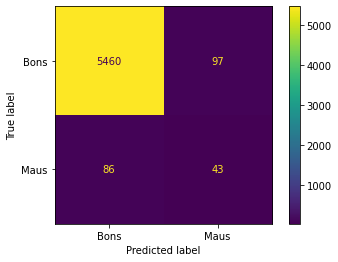


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5557
           1       0.31      0.33      0.32       129

    accuracy                           0.97      5686
   macro avg       0.65      0.66      0.65      5686
weighted avg       0.97      0.97      0.97      5686



In [55]:
# Usando o pipeline para transformar os dados como necessario, balanceando os dados de forma sintetica com o 'SMOTE', 
#e escolhendo o modelo com seu dicionario de melhor combinação de parametros.
pipe_DTC_melhores_parametros_RSCV = Pipeline(steps=[('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)), 
                            ('sampling', SMOTE(random_state=SEED)), 
                            ("modelo",  DecisionTreeClassifier(**DTC_melhores_parametros_RSCV))])
print("DecisionTreeClassifier com RandomSearchCV")
roda_modelo(pipe_DTC_melhores_parametros_RSCV, df_registro_clientes_targets)

### GridSearchCV

#### DecisionTreeClassifier

In [36]:
# Criando um diciconarios para a escolha dos parametros para usar o GridCV 
# Dicionario para buscar a melhor escolha de parâmetros do DecisionTreeClassifier com GridSearchCV

params_GSCV_DTC = {"classifier__max_depth": [3, None],
              "classifier__splitter": ['best', 'random'],
              "classifier__min_samples_split": [1, 2, 3, 10],
              "classifier__min_samples_leaf": [1, 2, 3, 10],
              "classifier__criterion": ["gini", "entropy"],
              "classifier__max_features":['auto', 'sqrt', 'log2'],
              "classifier__random_state": [1561651]}

In [37]:
# Usarei o mesmo Pipeline  de dados que anteriormente.
pipeline_busca_tree = Pipeline([('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)),
                        ('sampling', SMOTE(random_state=SEED)),
                        ('classifier', DecisionTreeClassifier())])

# Separação basica de dados.
x = df_registro_clientes_targets.drop(['ID_Cliente', 'Mau'], axis=1)
y = df_registro_clientes_targets.drop('ID_Cliente', axis=1)['Mau']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED)

# Então usarei a função busca_GridSearchCV para buscar a melhor coompinação possivel com o GridSearchCV.
rf_decision_Grid = GridSearchCV(pipeline_busca_tree, params_GSCV_DTC, cv = 3, verbose=2,  n_jobs = -1)
rf_decision_Grid.fit(x_train, y_train)
rf_decision_Grid.best_params_

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


{'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__random_state': 1561651,
 'classifier__splitter': 'best'}

In [38]:
# Dicionario com os melhores parametros do DecisionTreeClassifier com o GridSearchCV
DTC_melhores_parametros_GSCV =   {
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'random_state': 1561651,
  'splitter': 'best'
}

 BEST GridSearchCV DecisisonTreeClassifier
AUC 0.7210111417543067
KS KstestResult(statistic=0.946535349982413, pvalue=0.0)


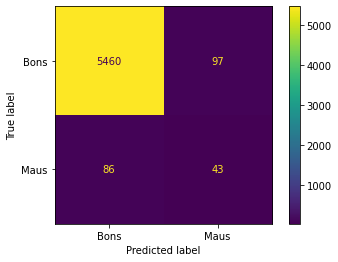


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5557
           1       0.31      0.33      0.32       129

    accuracy                           0.97      5686
   macro avg       0.65      0.66      0.65      5686
weighted avg       0.97      0.97      0.97      5686



In [40]:
# Usando o pipeline para transformar os dados como necessario, balanceando os dados de forma sintetica com o 'SMOTE', 
#e escolhendo o modelo com seu dicionario de melhor combinação de parametros.
pipe_best_busca_tree_Grid = Pipeline(steps=[('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)), 
                            ('sampling', SMOTE(random_state=SEED)), 
                            ("modelo",  DecisionTreeClassifier(**DTC_melhores_parametros_GSCV))])
print("Melhor DecisisonTreeClassifier com GridSearchCV")
# A função para rodar o modelo com os dados fazer a predição e potar a matriz de confusão.
roda_modelo(pipe_best_busca_tree_Grid, df_registro_clientes_targets)

#### RandomForestClassifier

In [41]:
# Criando um dicionário para a escolha dos parâmetros com o GridSearchCV.
params_RFC_GSCV = {"classifier__max_depth": [3, None],
              "classifier__max_features": [1, 3, 10],
              "classifier__min_samples_split": [1, 3, 10],
              "classifier__min_samples_leaf": [1, 3, 10],
              "classifier__bootstrap": [True, False],
              "classifier__criterion": ["gini", "entropy"],
              "classifier__n_estimators": [200, 400, 600, 800, 1000],
              "classifier__max_features":['auto', 'sqrt', 'log2']}

In [42]:
# 6h 8m p rodar
# Usarei o mesmo Pipeline  de dados que anteriormente.
pipeline_busca_random_Grid = Pipeline([('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)), ('classifier', RandomForestClassifier())])

# Separação básica de dados.
x = df_registro_clientes_targets.drop(['ID_Cliente', 'Mau'], axis=1)
y = df_registro_clientes_targets.drop('ID_Cliente', axis=1)['Mau']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=SEED)

# Então usarei a função busca_GridSearchCV_RFC para buscar a melhor coompinação possível com o GridSearchCV.
rf_random_grid = GridSearchCV(pipeline_busca_random_Grid, params_RFC_GSCV, cv = 3, verbose=2,  n_jobs = -1)
rf_random_grid.fit(x_train, y_train)
rf_random_grid.best_params_

In [53]:
# Dicionario com os melhores parâmetros do RandomForestClassifier com GridSearchCV
RFC_melhores_parametros_GSCV = {
 'random_state': 1561651,
 'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

Melhor RandomTreeClassifier com GridSearchCV
AUC 0.838113253344828
KS KstestResult(statistic=0.9695743932465706, pvalue=0.0)


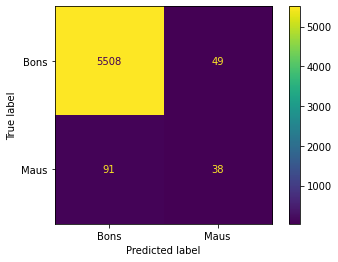


Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5557
           1       0.44      0.29      0.35       129

    accuracy                           0.98      5686
   macro avg       0.71      0.64      0.67      5686
weighted avg       0.97      0.98      0.97      5686



In [60]:
#Sipa esse
# Usando o pipeline para transformar os dados como necessário, balanceando os dados de forma sintética com o 'SMOTE',
# e escolhendo o modelo com seu dicionário de melhor combinação de parâmetros.

pipe_best_busca_random_Grid = Pipeline(steps=[('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)), 
                            ('sampling', SMOTE(random_state=SEED)), 
                            ("modelo",  RandomForestClassifier(**RFC_melhores_parametros_GSCV))])
                            
print("Melhor RandomTreeClassifier com GridSearchCV")
roda_modelo(pipe_best_busca_random_Grid, df_registro_clientes_targets)

### Comparando modelos hyperparametrados

In [64]:
url3 ='https://raw.githubusercontent.com/HammadN98/Melhor_ML/main/Dados/HyperModelos.csv'
Modelos_hyperss = pd.read_csv(url3)
Modelos_hyperss

,Modelos,Search,AUC,KS,BonsXBons,BonsXMaus,MausXBons,MausXMaus,acc,precision 0,precision 1
0,RandomForestClassifier,RandomSearchCV,"0,839","0,97",5511,46,91,38,"0,98","0,98","0,45"
1,DecisionTreeClassifier,RandomSearchCV,"0,72","0,946",5460,97,87,43,"0,97","0,98","0,31"
2,DecisionTreeClassifier,GridSearchCV,"0,72","0,946",5460,97,87,43,"0,97","0,98","0,31"
3,RandomForestClassifier,GridSearchCV,"0,838","0,969",5508,49,92,38,"0,98","0,98","0,44"


### Salvando o modelo escolhido

In [ ]:
pipeline = Pipeline([('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)),
                     ('sampling', SMOTE(random_state=SEED)),
                     ('Modelo', RandomForestClassifier(random_state=SEED))])

In [14]:
pipeline_salvo = Pipeline(steps=[('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)), 
                            ('sampling', SMOTE(random_state=SEED)), 
                            ("Modelo", RandomForestClassifier(**RFC_melhores_parametros_RSCV))])

In [10]:
pipelines = Pipeline(steps=[('Transformador', Transformador(colunas_quantitativas, colunas_categoricas)), 
                            ('sampling', SMOTE(random_state=SEED)), 
                            ("Modelo", RandomForestClassifier(**RFC_melhores_parametros_RSCV))])

In [12]:
x = df_registro_clientes_targets.drop(['ID_Cliente', 'Mau'], axis=1)
y = df_registro_clientes_targets['Mau']
    
pipelines.fit(x, y)

Pipeline(steps=[('Transformador',
                 Transformador(colunas_categoricas=['Tem_Carro',
                                                    'Tem_Casa_Propria',
                                                    'Categoria_de_renda',
                                                    'Grau_Escolaridade',
                                                    'Estado_Civil', 'Moradia',
                                                    'Tem_telefone_trabalho',
                                                    'Tem_telefone_fixo',
                                                    'Tem_email', 'Ocupacao'],
                               colunas_quantitativas=['Idade', 'Qtd_Filhos',
                                                      'Rendimento_Anual',
                                                      'Anos_empregado',
                                                      'Tamanho_Familia'])),
                ('sampling', SMOTE(random_state=1561651)),
                (

In [15]:
dump(pipeline_salvo, 'modelo_salvo.joblib')

['modelo_salvo.joblib']

In [13]:
dump(pipelines,'modelos.joblib')


['modelos.joblib']

In [ ]:
dump(pipeline,'modelo.joblib')

['modelo.joblib']

In [ ]:
features = x.columns
dump(features, 'features.joblib')


Index(['Unnamed: 0', 'Idade', 'Qtd_Filhos', 'Rendimento_Anual',
       'Anos_empregado', 'Tamanho_Familia', 'Tem_Carro', 'Tem_Casa_Propria',
       'Tem_telefone_trabalho', 'Tem_telefone_fixo', 'Tem_email',
       'Categoria_de_renda', 'Grau_Escolaridade', 'Estado_Civil', 'Moradia',
       'Ocupacao'],
      dtype='object')

In [ ]:
lista_campos = df_registro_clientes_targets[colunas_categoricas_nao_binarias].apply(lambda  x: x.unique(),axis=0)
dump(lista_campos, 'lista_campos.joblib')


Categoria_de_renda    [Empregado, Associado comercial, Pensionista, ...
Grau_Escolaridade     [Ensino medio, Ensino superior, Ensino superio...
Estado_Civil          [Casado, Solteiro, Separado, Uniao estavel, Vi...
Moradia               [Casa propria, Alugado, Habitacao publica, Mor...
Ocupacao              [Seguranca, Venda, Outros, Contabilidade, Cons...
dtype: object